In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math 
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
import random

In [2]:
df= pd.read_csv('C:/Users/sid31/Downloads/New folder/semester 2/machine learning/python exercises/regression/housing.csv')


In [100]:
class Regressor:
    def __init__(self, X, y, tol , learning_rate, iterations, reg_param,SGDiterations,batch_size , gd= False, regp = False, sgd = False):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.tol = tol 
        #self.m , self.n = self.X.shape
        self.gd = gd
        self.iterations_count = []
        self.error_seq = []
        self.reg_param = reg_param
        self.regp = regp
        self.sgd = sgd
        self.SGDiterations = SGDiterations
        self.batch_size = batch_size
        
    def trainTestSplit(self):
        x_train , x_test, y_train, y_test = train_test_split(self.X,self.y, test_size = 0.3, random_state = 0)
        return x_train , x_test, y_train, y_test
    
    def addBias(self,X):
        return np.column_stack([np.ones((X.shape[0],1)),X])
    
    def normData(self,X):
        mean = np.mean(X, 0)
        std =  np.std(X , 0)
        nor =  ( X - mean) / std
        x_norm = self.addBias(nor)
        return x_norm, mean, std # retrun std and mean so that you need to normalise test data on this mean and std 
    
    def normTestData(self, X, TrainMean, TrainStd):
        x_norm = ( X - TrainMean ) / TrainStd
        x_norm = self.addBias(x_norm)
        return x_norm
    
    # closed form or normal equation 
    # find rank of the matrix to see full rank to evaluate invertibility 
    
    def rank(self, X, esp = 1e-21):
        u ,s ,vh = np.linalg.svd(X)
        # s is diagonol matrix - if all values of s are not 0 and >0 we are good 
        
        return len([x for x in s if abs(s) > esp])
    # anathor way to check the rnak of matix
    def checkMatrix(self,X):
        
        x_rank  = np.linalg.matrix_rank(X)
        if x_rank == min(X.shape[0], X.shape[1]):
            self.fullRank = True
            print('Data is full rank')
        else:
            self.fullRank = False
            print('Data not full rank')
            
    def checkInvertibility(self,X):
        if X.shape[0] < X.shape[1]:
            self.lowRank = True
            print('Data is low rank')
        else:
            self.lowRank = False
            print('Data is not low rank')
    
    def normalEq(self,X,y):
        w = np.linalg.inv(np.dot(X.T,X)).dot(X.T).dot(y)
        return w
    
    def regNormalEquation(self,X,y):
        w = np.linalg.inv( np.dot(X.T,X) + self.reg_param * ( np.identity(X.shape[1]) )  ).dot(X.T).dot(y)
        return w
    
    
    def gradientDescent(self,X,y):
        #error_seq = []
        prev_error = float('inf')
        
        for t in tqdm(range(self.iterations)):
            self.w = self.w - self.learning_rate * self.costDerivative(X,y)
            cur = self.rmse(X,y)
            diff = prev_error - cur
            prev_error = cur
            self.error_seq.append(cur)
            self.iterations_count.append(t)
            
            if diff < self.tol: # in real life you need to wait patience* until certain iterations before you break
                print("model stopped - no further updating")
                break          
                
    def regGradientDescent(self, X,y):
        
        prev_error = float('inf')
        
        for t in tqdm(range(self.iterations)):
            w_update = self.w * (1 - self.learning_rate *( self.reg_param / X.shape[0]))
            self.w  = w_update - (self.learning_rate  * self.regCostDerivative(X,y))  
            cur = self.rmse(X,y)
            diff = prev_error - cur
            prev_error = cur
            self.error_seq.append(cur)
            self.iterations_count.append(t)
            
            if diff < self.tol: # in real life you need to wait patience* until certain iterations before you break
                print("model stopped - no further updating")
                break
                
    def sgradientDescent(self, X, y ,batch_size):
        prev_error = float('inf')
        
        for t in tqdm(range(self.SGDiterations)):
            seq = []
            idx = np.random.randint(0, X.shape[0], batch_size)
            #x_sgd = X[idx]
            #y_sgd = y[idx]
            #print(x_sgd)
            #for i in range(batch_size):
            self.w = self.w - self.learning_rate * self.costDerivative(X[idx],y[idx])
            cur = self.rmse(X[idx],y[idx])
            diff = prev_error - cur
            prev_error = cur
            #seq.append(cur)
            self.error_seq.append(cur)
            self.iterations_count.append(t)
            
            if diff < self.tol: # in real life you need to wait patience* until certain iterations before you break
                print("model stopped - no further updating")
                break
        
    def regSGradientDescent(self,X,y, batch_size):
        prev_error = float('inf')
        
        for t in tqdm(range(self.SGDiterations)):
            seq = []
            idx = np.random.randint(0, X.shape[0], batch_size)
            #x_sgd = X[idx]
            #y_sgd = y[idx]
            #for i in range(batch_size):
            w_update = self.w * (1 - self.learning_rate * (self.reg_param / batch_size ))
            self.w  = w_update - (self.learning_rate  * self.regCostDerivative(X[idx],y[idx]))
                #self.W = slef.w - self.learning_rate * self.costDerivative(X[i,:],y[i,1])
            cur = self.rmse(X[idx],y[idx])
            diff = prev_error - cur
            prev_error = cur
            #seq.append(cur)
            #self.error_seq.append(np.mean(seq))
            self.error_seq.append(cur)
            self.iterations_count.append(t)
            
            if diff < self.tol: # in real life you need to wait patience* until certain iterations before you break
                print("model stopped - no further updating")
                break
        
            
    def sse(self,X,y):
        y_hat = self.predict(X)
        return ((y_hat - y)**2).sum()
    
    def rmse(self,X,y):
        dum = self.sse(X,y)
        return np.sqrt(dum / X.shape[0])
    
    def predict(self,X):
        return X.dot(self.w)
    
    def costFunc(self,X, y):
        return self.sse(X,y)/2
    
    def regCostFunc(self,X,y):
        return ( self.sse(X,y) + (self.reg_param * np.dot(X.T,X).sum()) ) / 2
    
    def costDerivative(self,X,y):
        y_hat = self.predict(X)
        return np.dot(y_hat - y , X)
    
    def regCostDerivative(self,X,y):
        y_hat = self.predict(X)
        return np.dot(y_hat - y , X) / X.shape[0]
    
    
    def fit(self):
        self.x_train , self.x_test, self.y_train, self.y_test = self.trainTestSplit()
        self.x_train, self.mean, self.std = self.normData(self.x_train)
        self.x_test = self.normTestData(self.x_test, self.mean, self.std)
        
        self.checkMatrix(self.x_train)
        self.checkInvertibility(self.x_train)
        
        if self.fullRank and not self.lowRank and not self.gd and not self.sgd:
            print("solving using normal equation...")
            if not self.regp:
                print("without regularisation")
                self.w = self.normalEq(self.x_train, self.y_train)
                
            else: 
                print("with regularisation")
                self.w = self.regNormalEquation(self.x_train, self.y_train)
            
        elif not self.sgd: 
            print("solving using gradient descent...")
            self.w = np.ones(self.x_train.shape[1], dtype = np.float64) *0
            
            if not self.regp:
                print("without regularisation ")
                self.gradientDescent(self.x_train,self.y_train)
                
            else: 
                print("with regularisation")
                self.regGradientDescent(self.x_train,self.y_train)
                
        else: 
            print("solving using stochastic gradient descent...")
            self.w = np.ones(self.x_train.shape[1], dtype = np.float64) *0
            
            if not self.regp:
                print("without regularisation ")
                
                self.sgradientDescent(self.x_train,self.y_train, self.batch_size)
                
            else: 
                print("with regularisation")
                self.regSGradientDescent(self.x_train,self.y_train, self.batch_size)
                
                
            
        print(self.w)
        
    def plotError(self, figsize=(7,5)):
        
        plt.figure(figsize=figsize)
        plt.plot(self.iterations_count,self.error_seq)
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title("Iterations vs Cost")
        plt.show()
        
    #def score(self,X,y):
        #return 1-(np.sum(((y-self.predict(X))**2))/np.sum((y-np.mean(y))**2))
        
        

Data is full rank
Data is not low rank
solving using gradient descent...
without regularisation 


  0%|                                                                            | 77/50000 [00:00<00:01, 34552.41it/s]

model stopped - no further updating
[22.93383436 -0.81185672  0.85530938  0.03211444  0.70915052 -1.73753723
  2.77445739  0.27473915 -2.42577381  1.3282749  -0.74123035 -2.23243855
  0.65681149 -3.86537883]


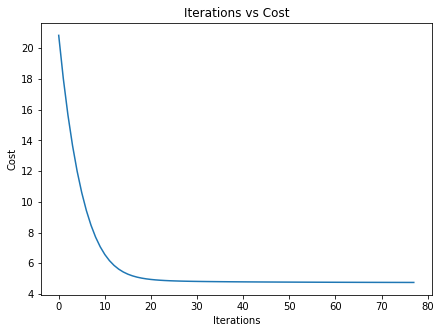

In [104]:
reg = Regressor(df.values[:,0:-1], df.values[:,-1], learning_rate= 0.0004, tol = 0.0005, iterations = 50000, 
                SGDiterations = 100,reg_param = 0.001, batch_size= 1
               , gd = True, regp = False, sgd = False )
reg.fit()
reg.plotError()

In [129]:
#reg.score(reg.x_test,reg.y_test)

0.7259619076555617

In [108]:
df1 = pd.read_csv('C:/Users/sid31/Downloads/New folder/semester 2/machine learning/python exercises/regression/concreteData.csv')

Data is full rank
Data is not low rank
solving using stochastic gradient descent...
with regularisation


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 143.69it/s]


[34.51330734  7.47141603  3.65441951  0.84156321 -5.02935683  3.229718
 -1.42145666 -2.79403135  6.80897745]


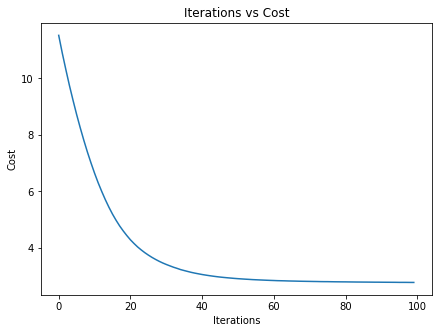

In [137]:
reg1 = Regressor(df1.values[:,0:-1], df1.values[:,-1], learning_rate= 0.0007, tol = 0.0001, iterations = 50000,
                 SGDiterations = 100, reg_param = 0.003
               , gd = False, regp = True, sgd = True)
reg1.fit()
reg1.plotError()

In [138]:
#reg1.score(reg1.x_test,reg1.y_test)

0.5140276636360909

In [139]:
df2 = pd.read_csv('C:/Users/sid31/Downloads/New folder/semester 2/machine learning/python exercises/regression/yachtData.csv')

Data is full rank
Data is not low rank
solving using stochastic gradient descent...
with regularisation


100%|█████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 435.99it/s]

[ 6.86005323  0.46594353 -0.4015521  -0.13194189 -0.04428006 -0.16040058
  8.2344307 ]


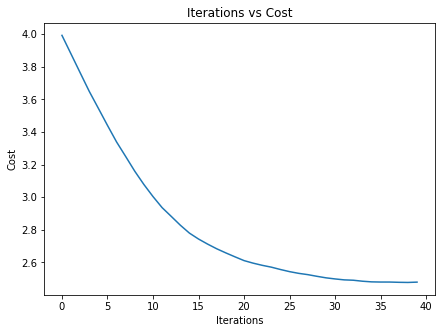

In [146]:
reg2 = Regressor(df2.values[:,0:-1], df2.values[:,-1], learning_rate= 0.001, tol = 0.001, iterations = 50000,
                 SGDiterations = 40, reg_param = 0.03
               , gd = False, regp = True, sgd = True)
reg2.fit()
reg2.plotError()

In [147]:
#reg2.score(reg2.x_test,reg2.y_test)

0.5223867974584235

In [ ]:
t in iterations: # iterations  - 1-10 
   i in range(x.shape[0]): # go through all the data points one at a time 
    update theta # update theta one at a time 
    error_seq.append(curr_error) # append errors for one iteration 
   error.append(mean(error_seq)) # mean of errors in one iteration 